In [1]:
import os
from pathlib import Path
from warnings import simplefilter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

[utils source][1]

[1]: https://github.com/Kaggle/learntools/tree/master/learntools/time_series

In [2]:
# from utils import lagplot, plot_lags, make_lags, make_leads

In [3]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

## Читаем `csv` файлы из отдельной директории

In [5]:
#Папка где у меня файлы
path = "f:\\Datasets\\kaggle-store-sales"

# ШАГ 1. Запоминаем текущую папку и меняем ее на нужную = где файл лежит
# Check current working directory.
main_path = os.getcwd()
print("Current working directory", main_path)

# Now change the directory
os.chdir( path )

# Check current working directory.
cur_path = os.getcwd()
print("Directory changed successfully",cur_path)

# ШАГ 2. Читаем файл в датафрейм df (оперативную память) для трансформации
# прочитаем файл
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date']
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)    

# ШАГ 3. Возвращаем основную рабочую директорию 
os.chdir(main_path)
cur_path = os.getcwd()
print("Directory changed successfully", cur_path)

Current working directory g:\github_projects\study-time-series-analysis\kaggle-ts
Directory changed successfully f:\Datasets\kaggle-store-sales
Directory changed successfully g:\github_projects\study-time-series-analysis\kaggle-ts


In [7]:
store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [6]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

you'll create a boosted hybrid for the Store Sales dataset by implementing a new Python class. Run this cell to create the initial class definition. You'll add fit and predict methods to give it a scikit-learn like interface.

In [9]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

# 1) Define fit method for boosted hybrid¶
Complete the fit definition for the BoostedHybrid class. Refer back to steps 1 and 2 from the Hybrid Forecasting with Residuals section in the tutorial if you need.

In [10]:
def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    self.model_1.fit(X_1,y)

    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y-y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

# 2) Define predict method for boosted hybrid
Now define the `predict` method for the `BoostedHybrid` class. Refer back to step 3 from the **Hybrid Forecasting with Residuals** section in the tutorial if you need.

In [11]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict

Now you're ready to use your new `BoostedHybrid` class to create a model for the *Store Sales* data. Run the next cell to set up the data for training

In [12]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [15]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [16]:
family_sales.columns

MultiIndex([(      'sales',                 'AUTOMOTIVE'),
            (      'sales',                  'BABY CARE'),
            (      'sales',                     'BEAUTY'),
            (      'sales',                  'BEVERAGES'),
            (      'sales',                      'BOOKS'),
            (      'sales',               'BREAD/BAKERY'),
            (      'sales',                'CELEBRATION'),
            (      'sales',                   'CLEANING'),
            (      'sales',                      'DAIRY'),
            (      'sales',                       'DELI'),
            (      'sales',                       'EGGS'),
            (      'sales',               'FROZEN FOODS'),
            (      'sales',                  'GROCERY I'),
            (      'sales',                 'GROCERY II'),
            (      'sales',                   'HARDWARE'),
            (      'sales',         'HOME AND KITCHEN I'),
            (      'sales',        'HOME AND KITCHEN II'

In [14]:
X_1.head()

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0


In [13]:
X_2.head()

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1


# 3) Train boosted hybrid
Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [17]:
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(LinearRegression(), XGBRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

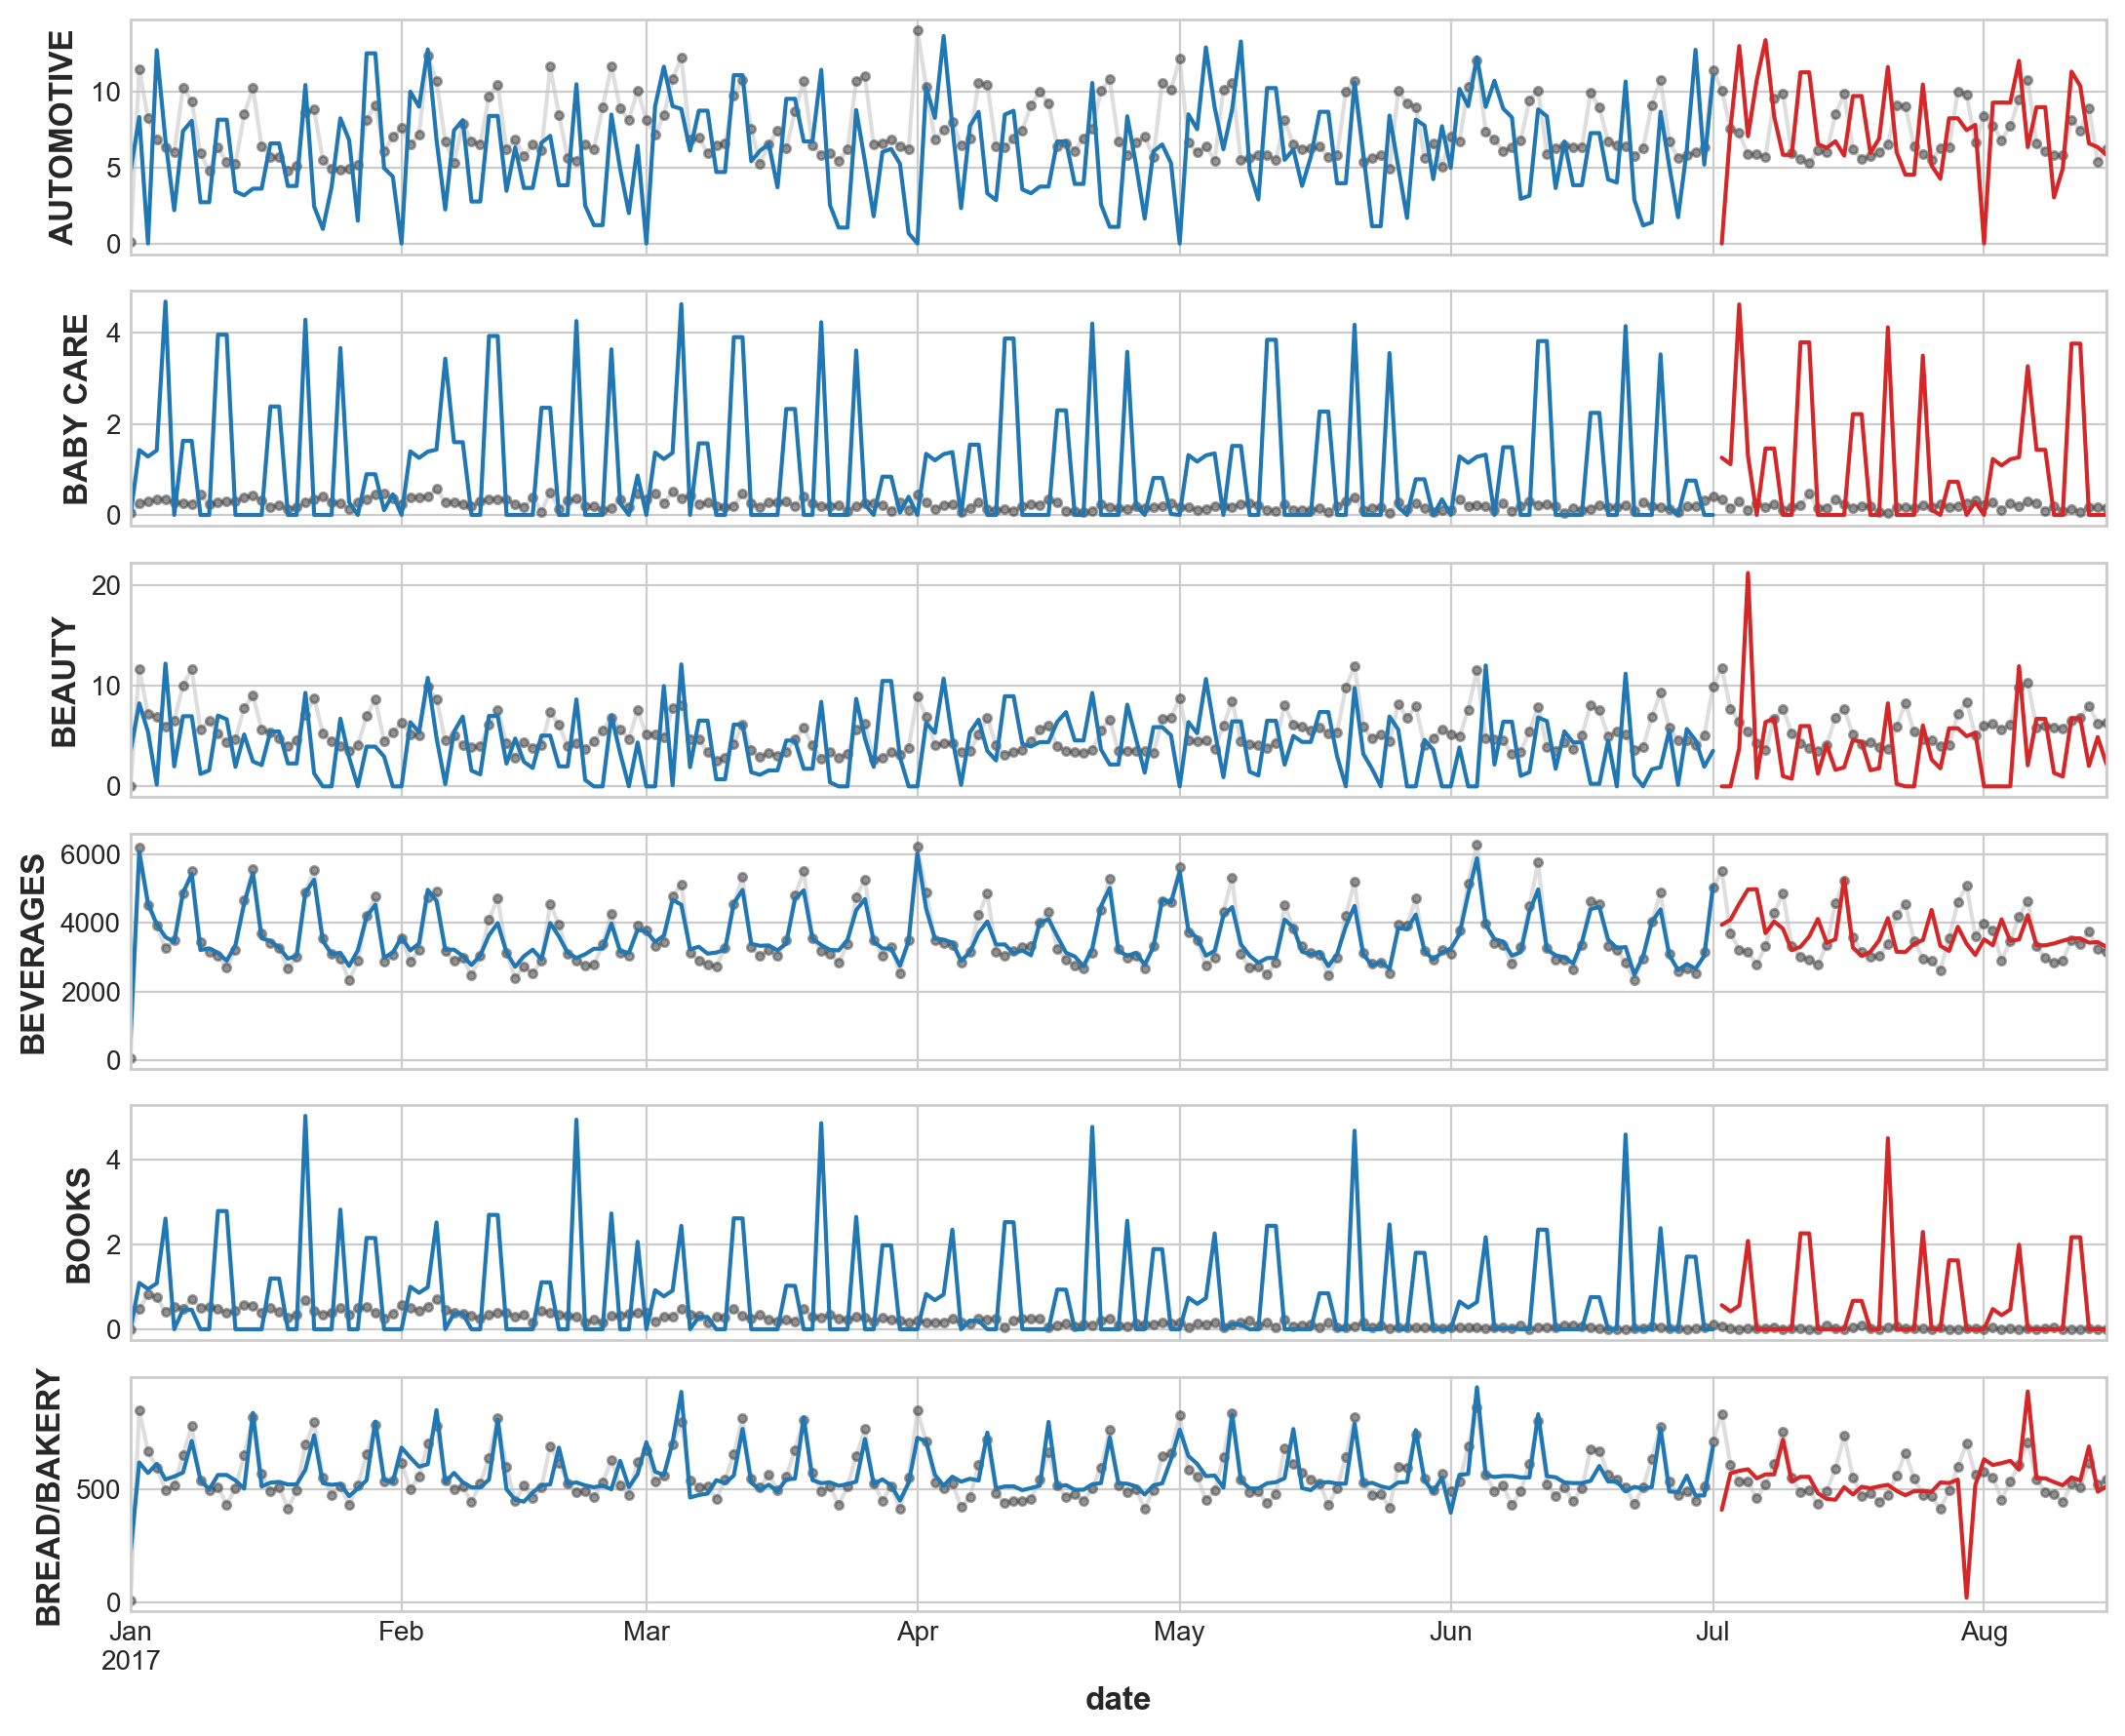

In [18]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous questions. Run the next cell to try other algorithms from scikit-learn.

In [21]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model2 = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

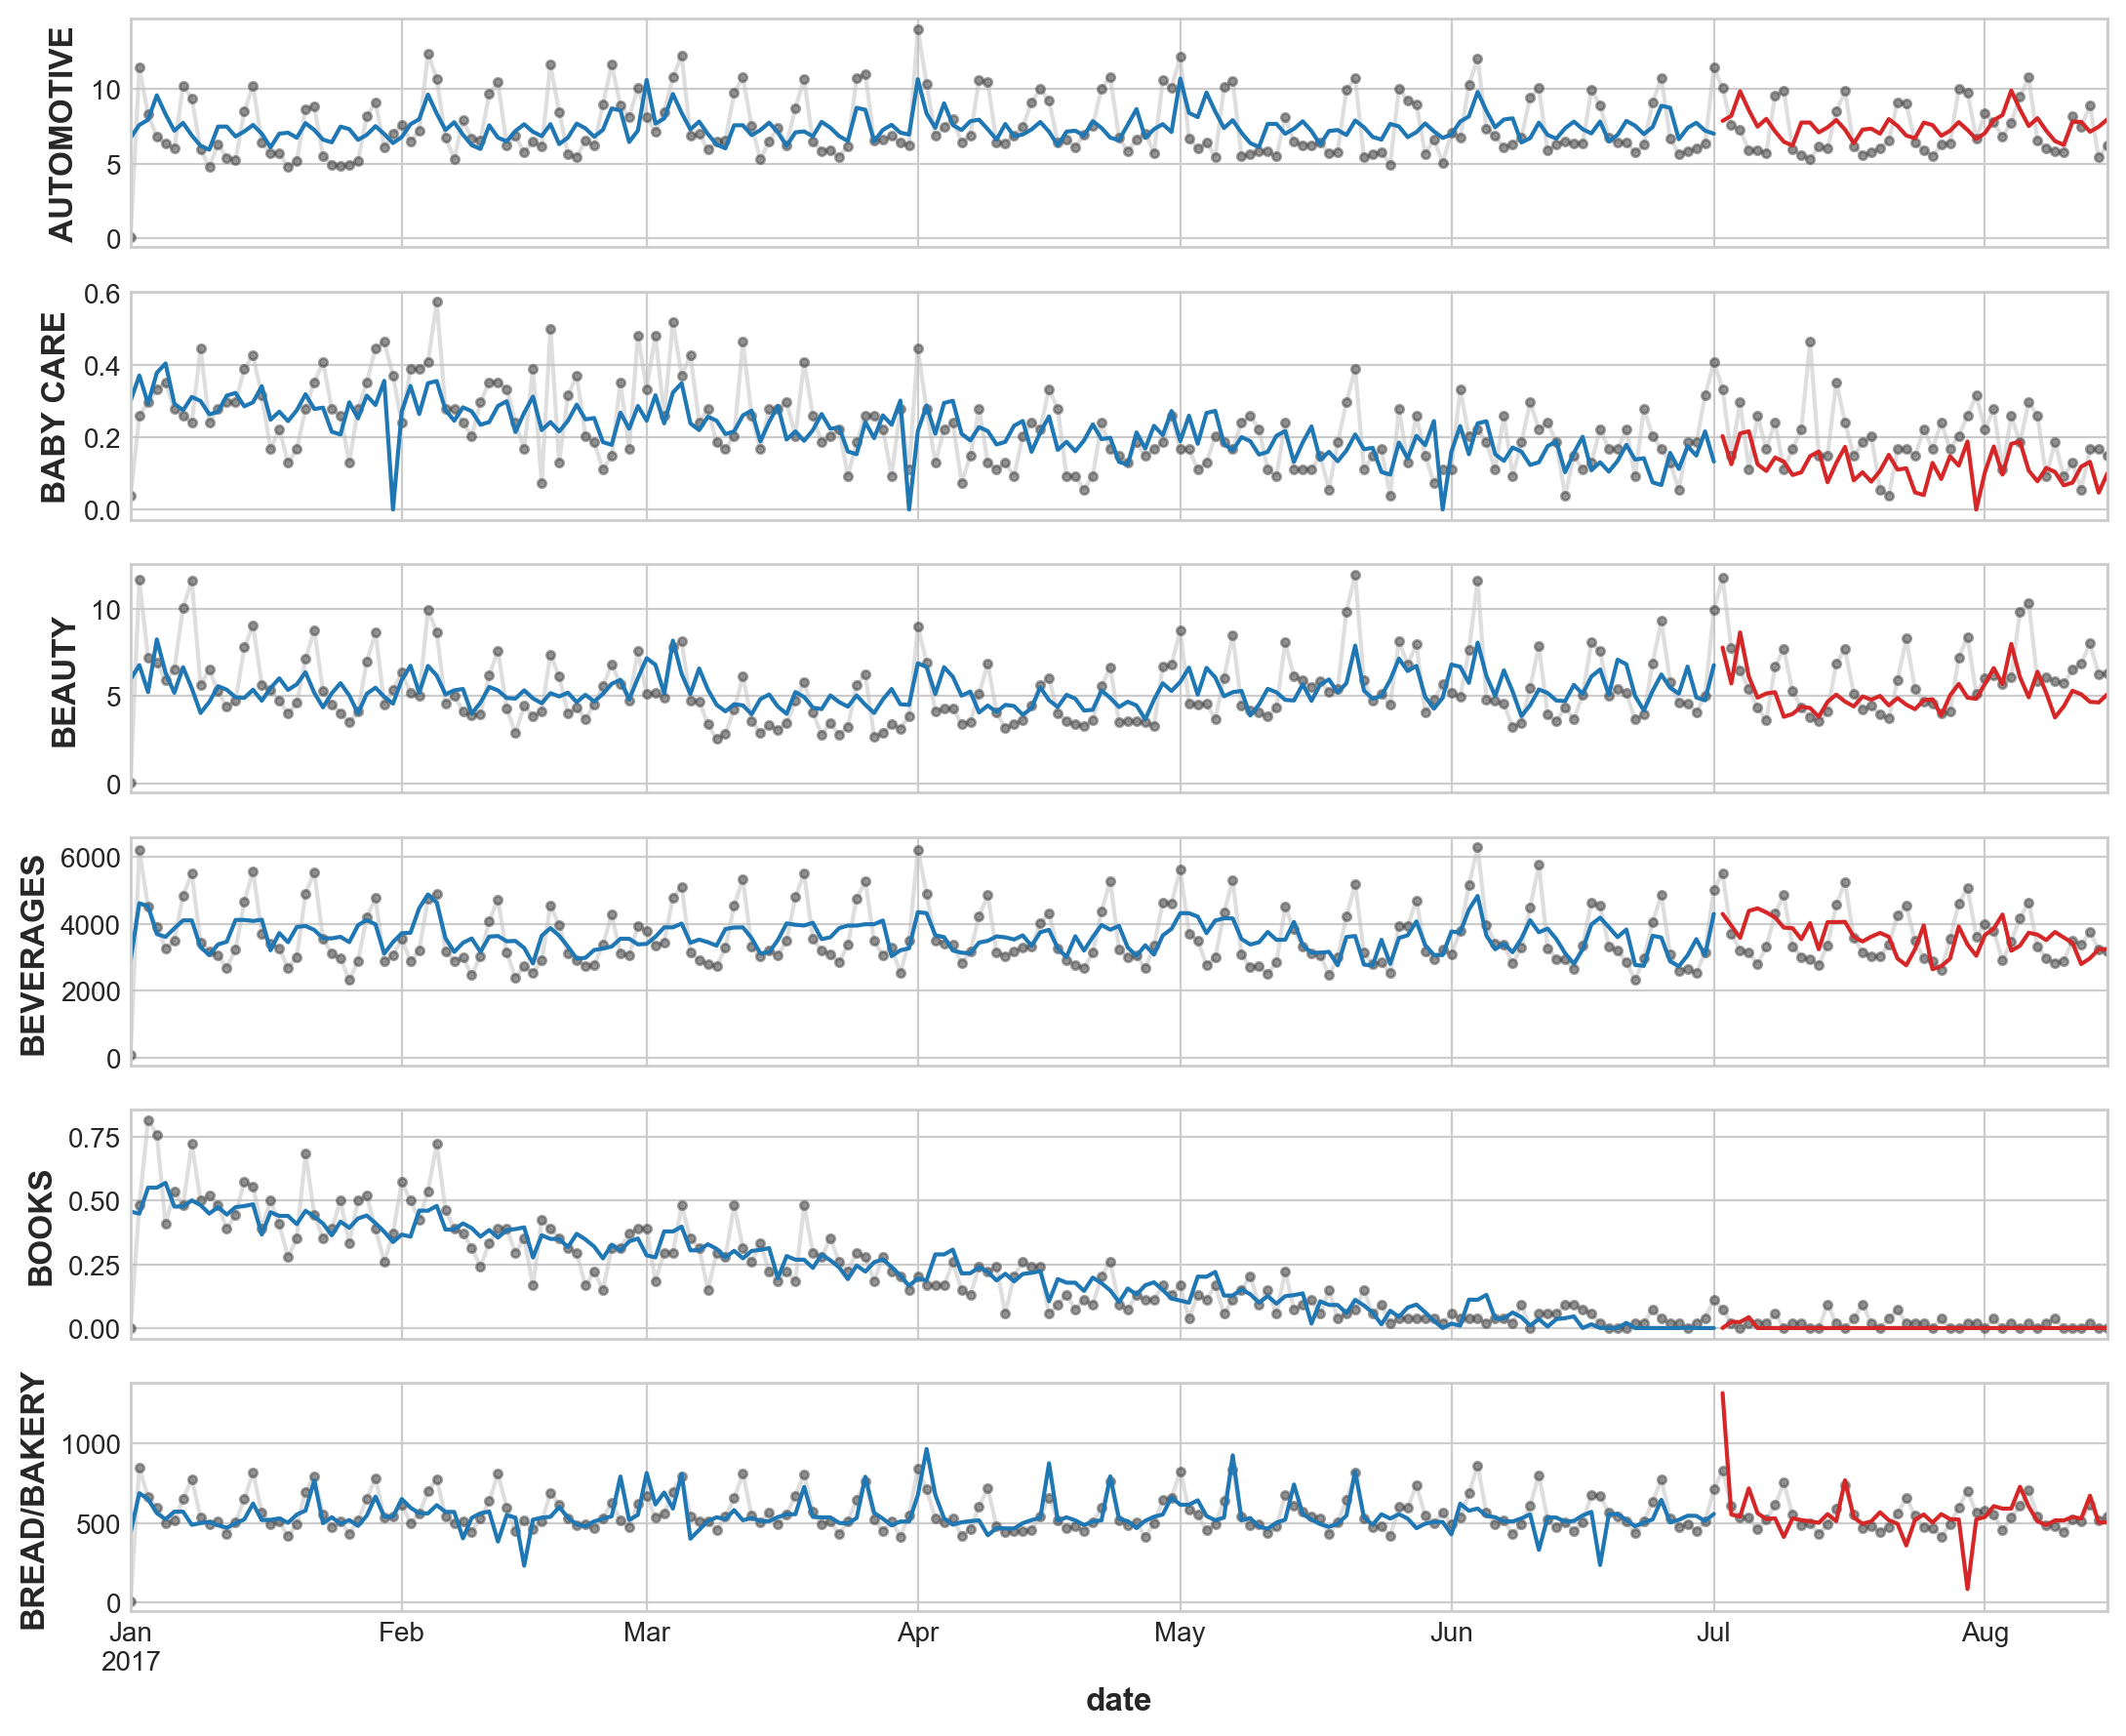

In [23]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model2.fit(X1_train, X2_train, y_train)
y_fit = model2.predict(X1_train, X2_train).clip(0.0)
y_pred = model2.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)